In [136]:
COST_PER_MAIL = 0.50
PROFIT_PER_SALE = 6.00
BREAKEVEN = COST_PER_MAIL / PROFIT_PER_SALE  # 0.0833333333


In [137]:
#Step 1.1

import pandas as pd

# Load the data
df = pd.read_csv("BBB.csv")

# Shape of the DataFrame
print("Shape:", df.shape)
print()

# First 5 rows
print("First 5 rows:")
print(df.head())
print()

# Summary statistics for selected columns
print("Summary statistics (last, purch, total$):")
print(df[["last", "purch", "total$"]].describe())
print()

# Overall buyer rate
overall_buyer_rate = df["buyer"].mean()
print(f"Overall buyer rate: {overall_buyer_rate:.3f}")
print()

# Buyer rate by gender
buyer_rate_by_gender = df.groupby("gender")["buyer"].mean()
print("Buyer rate by gender:")
print(buyer_rate_by_gender)


Shape: (50000, 19)

First 5 rows:
   acctnum gender state    zip  zip3  first  last  book$  nonbook$  total$  \
0    10001      M    NY  10605   106     49    29    109       248     357   
1    10002      M    NY  10960   109     39    27     35       103     138   
2    10003      F    PA  19146   191     19    15     25       147     172   
3    10004      F    NJ   7016    70      7     7     15       257     272   
4    10005      F    NY  10804   108     15    15     15       134     149   

   purch  child  youth  cook  do_it  refernce  art  geog  buyer  
0     10      3      2     2      0         1    0     2      0  
1      3      0      1     0      1         0    0     1      0  
2      2      0      0     2      0         0    0     0      0  
3      1      0      0     0      0         1    0     0      0  
4      1      0      0     1      0         0    0     0      0  

Summary statistics (last, purch, total$):
               last        purch        total$
count  5000

In [138]:
#Step 1.2

import pandas as pd
import statsmodels.api as sm

# Load data (if not already loaded)
df = pd.read_csv("BBB.csv")

# Define variables
X = df["purch"]
y = df["buyer"]

# Add intercept
X = sm.add_constant(X)

# Fit OLS
ols_model = sm.OLS(y, X).fit()

# Print regression summary
print(ols_model.summary())
print()

# Generate predictions
pred = ols_model.predict(X)

# Min and max of predictions
print(f"Min prediction: {pred.min():.3f}")
print(f"Max prediction: {pred.max():.3f}")
print()

# Share of predictions outside [0, 1]
outside_share = ((pred < 0) | (pred > 1)).mean()
print(f"Share of predictions outside [0,1]: {outside_share:.3f}")



                            OLS Regression Results                            
Dep. Variable:                  buyer   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     737.3
Date:                Fri, 06 Feb 2026   Prob (F-statistic):          3.50e-161
Time:                        01:10:38   Log-Likelihood:                -8134.4
No. Observations:               50000   AIC:                         1.627e+04
Df Residuals:                   49998   BIC:                         1.629e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0517      0.002     27.079      0.0

In [139]:
#Step 1.3

import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv("BBB.csv")

# Variables
X = df[["purch"]]   # sklearn expects 2D
y = df["buyer"]

# Fit logistic regression
logit = LogisticRegression(solver="lbfgs")
logit.fit(X, y)

# Predicted probabilities
df["p_hat"] = logit.predict_proba(X)[:, 1]

# Targeting cutoff
cutoff = 0.0833

# Targeted mailing
mailed = df["p_hat"] >= cutoff
num_mailed = mailed.sum()
buyers_mailed = df.loc[mailed, "buyer"].sum()

cost = 0.50 * num_mailed
sales = 6.0 * buyers_mailed
profit = sales - cost
rome = profit / cost

print("Logistic targeting results")
print("---------------------------")
print(f"# mailed: {num_mailed}")
print(f"# buyers mailed: {buyers_mailed}")
print(f"Cost: {cost:.2f}")
print(f"Sales: {sales:.2f}")
print(f"Profit: {profit:.2f}")
print(f"ROME: {rome:.3f}")
print()

# Mass mailing (mail everyone)
total_mailed = len(df)
total_buyers = df["buyer"].sum()

mass_cost = 0.50 * total_mailed
mass_sales = 6.0 * total_buyers
mass_profit = mass_sales - mass_cost

print("Mass mailing results")
print("--------------------")
print(f"Profit (mass mailing): {mass_profit:.2f}")


Logistic targeting results
---------------------------
# mailed: 17926
# buyers mailed: 2346
Cost: 8963.00
Sales: 14076.00
Profit: 5113.00
ROME: 0.570

Mass mailing results
--------------------
Profit (mass mailing): 2132.00


In [140]:
#Step 1.4

import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv("BBB.csv")

# --------------------
# Feature preparation
# --------------------

# Rename total$
df = df.rename(columns={"total$": "total_spent"})

# One-hot encode gender, drop first category
df = pd.get_dummies(df, columns=["gender"], drop_first=True)

# Convert boolean dummies to int (0/1), if any
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Define variables
features = ["purch", "last", "total_spent"] + \
           [c for c in df.columns if c.startswith("gender_")]

X = df[features]
y = df["buyer"]

# --------------------
# statsmodels Logit
# --------------------

X_sm = sm.add_constant(X)
logit_sm = sm.Logit(y, X_sm).fit(disp=False)

print(logit_sm.summary())
print()

# --------------------
# sklearn Logit for predict_proba
# --------------------

logit_sk = LogisticRegression(solver="lbfgs", max_iter=1000)
logit_sk.fit(X, y)

df["p_hat"] = logit_sk.predict_proba(X)[:, 1]

# --------------------
# Targeting at cutoff
# --------------------

cutoff = 0.0833
mailed = df["p_hat"] >= cutoff

num_mailed = mailed.sum()
buyers_mailed = df.loc[mailed, "buyer"].sum()

cost = 0.50 * num_mailed
sales = 6.0 * buyers_mailed
profit = sales - cost
rome = profit / cost

print("Multi-variable logistic targeting results")
print("-----------------------------------------")
print(f"# mailed: {num_mailed}")
print(f"# buyers mailed: {buyers_mailed}")
print(f"Cost: {cost:.2f}")
print(f"Sales: {sales:.2f}")
print(f"Profit: {profit:.2f}")
print(f"ROME: {rome:.3f}")


                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49995
Method:                           MLE   Df Model:                            4
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                 0.07194
Time:                        01:10:38   Log-Likelihood:                -14086.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.2106      0.046    -48.268      0.000      -2.300      -2.121
purch           0.0828      0.005     16.476      0.000       0.073       0.093
last           -0.0827      0.003    -32.115    

In [141]:
#Step 1.5

import pandas as pd
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv("BBB.csv")

# --------------------
# Feature preparation
# --------------------

# Rename total$
df = df.rename(columns={"total$": "total_spent"})

# One-hot encode gender, keep explicit dummy name (e.g., gender_M)
df = pd.get_dummies(df, columns=["gender"], drop_first=True)

# Convert boolean dummies to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Create art_flag if art is a count
df["art_flag"] = (df["art"] > 0).astype(int)

# --------------------
# statsmodels Logit with interaction
# --------------------

# Formula with interaction (includes main effects automatically)
formula = (
    "buyer ~ purch + last + total_spent + gender_M + art_flag + gender_M * art_flag"
)

logit_model = smf.logit(formula=formula, data=df).fit(disp=False)

print(logit_model.summary())
print()

# --------------------
# Predictions & targeting
# --------------------

df["p_hat"] = logit_model.predict(df)

cutoff = 0.0833
mailed = df["p_hat"] >= cutoff

num_mailed = mailed.sum()
buyers_mailed = df.loc[mailed, "buyer"].sum()

cost = 0.50 * num_mailed
sales = 6.0 * buyers_mailed
profit = sales - cost
rome = profit / cost

print("Interaction model targeting results")
print("-----------------------------------")
print(f"# mailed: {num_mailed}")
print(f"# buyers mailed: {buyers_mailed}")
print(f"Profit: {profit:.2f}")
print(f"ROME: {rome:.3f}")


                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                  0.1252
Time:                        01:10:38   Log-Likelihood:                -13277.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.5759      0.052    -49.988      0.000      -2.677      -2.475
purch                -0.0027      0.006     -0.484      0.628      -0.014       0.008
last                 -0.

Top 10 feature importances:
art         0.594866
last        0.242530
geog        0.092794
gender_M    0.031559
do_it       0.029275
cook        0.006601
nonbook$    0.002374
state_RI    0.000000
state_PA    0.000000
state_MD    0.000000
dtype: float64


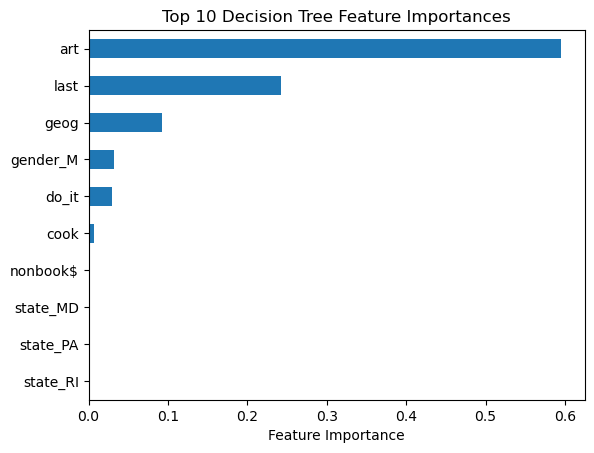

In [142]:
# Step 1.6

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# --------------------
# Load data
# --------------------
df = pd.read_csv("BBB.csv")

# Rename total$ if needed
if "total$" in df.columns:
    df = df.rename(columns={"total$": "total_spent"})

# --------------------
# Feature matrix
# --------------------
features = [
    "state", "first", "last", "book$", "nonbook$", "total_spent",
    "purch", "child", "youth", "cook", "do_it", "refernce",
    "art", "geog", "gender"
]

X = df[features]
y = df["buyer"]

# One-hot encode state and gender
X = pd.get_dummies(X, columns=["state", "gender"], drop_first=True)

# Ensure all features are numeric
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

# --------------------
# Train / test split
# --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# --------------------
# Decision Tree
# --------------------
tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=100,
    random_state=42
)
tree.fit(X_train, y_train)

# --------------------
# Feature importances
# --------------------
importances = pd.Series(tree.feature_importances_, index=X.columns)
top10 = importances.sort_values(ascending=False).head(10)

print("Top 10 feature importances:")
print(top10)

# --------------------
# Plot (horizontal bar chart)
# --------------------
plt.figure()
top10.sort_values().plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Top 10 Decision Tree Feature Importances")
plt.show()


In [143]:
#Step 1.7

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# --------------------
# Setup
# --------------------
df = pd.read_csv("BBB.csv")

# Rename total$ if needed
if "total$" in df.columns:
    df = df.rename(columns={"total$": "total_spent"})

# Gender dummy
df = pd.get_dummies(df, columns=["gender"], drop_first=True)

# Boolean → int
for c in df.columns:
    if df[c].dtype == bool:
        df[c] = df[c].astype(int)

# Art flag
df["art_flag"] = (df["art"] > 0).astype(int)

cutoff = 0.0833
cost_per_mail = 0.50
revenue_per_sale = 6.0

results = []

# --------------------
# 1. Mass mailing
# --------------------
mailed = len(df)
buyers_mailed = df["buyer"].sum()

cost = cost_per_mail * mailed
sales = revenue_per_sale * buyers_mailed
profit = sales - cost
rome = profit / cost

results.append([
    "Mass mailing", mailed, buyers_mailed, profit, rome
])

# --------------------
# 2. Logit: purch only
# --------------------
X = df[["purch"]]
y = df["buyer"]

logit1 = LogisticRegression(max_iter=1000)
logit1.fit(X, y)

df["p1"] = logit1.predict_proba(X)[:, 1]
mailed_mask = df["p1"] >= cutoff

mailed = mailed_mask.sum()
buyers_mailed = df.loc[mailed_mask, "buyer"].sum()

cost = cost_per_mail * mailed
sales = revenue_per_sale * buyers_mailed
profit = sales - cost
rome = profit / cost

results.append([
    "Logit: purch", mailed, buyers_mailed, profit, rome
])

# --------------------
# 3. Logit: purch + last + total_spent + gender
# --------------------
features = ["purch", "last", "total_spent"] + \
           [c for c in df.columns if c.startswith("gender_")]

X = df[features]

logit2 = LogisticRegression(max_iter=1000)
logit2.fit(X, y)

df["p2"] = logit2.predict_proba(X)[:, 1]
mailed_mask = df["p2"] >= cutoff

mailed = mailed_mask.sum()
buyers_mailed = df.loc[mailed_mask, "buyer"].sum()

cost = cost_per_mail * mailed
sales = revenue_per_sale * buyers_mailed
profit = sales - cost
rome = profit / cost

results.append([
    "Logit: multi-var", mailed, buyers_mailed, profit, rome
])

# --------------------
# 4. Logit with interaction: gender × art_flag
# --------------------
formula = (
    "buyer ~ purch + last + total_spent + gender_M + art_flag + gender_M * art_flag"
)

logit_int = smf.logit(formula, data=df).fit(disp=False)
df["p3"] = logit_int.predict(df)

mailed_mask = df["p3"] >= cutoff
mailed = mailed_mask.sum()
buyers_mailed = df.loc[mailed_mask, "buyer"].sum()

cost = cost_per_mail * mailed
sales = revenue_per_sale * buyers_mailed
profit = sales - cost
rome = profit / cost

results.append([
    "Logit: interaction", mailed, buyers_mailed, profit, rome
])

# --------------------
# Summary table
# --------------------
summary = pd.DataFrame(
    results,
    columns=["Strategy", "# Mailed", "# Buyers Mailed", "Profit", "ROME"]
)

print(summary)


'''
The interaction-based logistic regression gives the highest profit because it uses the most information 
and can better identify customers who are truly likely to buy, including differences in preferences 
across groups. The most efficient approach (highest ROME) is usually a simpler targeted logistic model, 
which mails to fewer people and keeps costs very low while still generating sales. Overall, more personalized, 
data-driven methods outperform simpler approaches because they account for differences in customer behavior, 
reduce wasted mailings, and focus marketing resources on the most promising customers 
rather than treating everyone the same.
'''

             Strategy  # Mailed  # Buyers Mailed   Profit      ROME
0        Mass mailing     50000             4522   2132.0  0.085280
1        Logit: purch     17926             2346   5113.0  0.570456
2    Logit: multi-var     22376             3312   8684.0  0.776189
3  Logit: interaction     17296             3225  10702.0  1.237512


'\nThe interaction-based logistic regression gives the highest profit because it uses the most information \nand can better identify customers who are truly likely to buy, including differences in preferences \nacross groups. The most efficient approach (highest ROME) is usually a simpler targeted logistic model, \nwhich mails to fewer people and keeps costs very low while still generating sales. Overall, more personalized, \ndata-driven methods outperform simpler approaches because they account for differences in customer behavior, \nreduce wasted mailings, and focus marketing resources on the most promising customers \nrather than treating everyone the same.\n'

In [144]:
#Step 2.A

'''
Based on the decision tree importances and consumer behavior logic, a strong refined logistic model would include purch, last, 
total_spent, art, gender, and first.

Purch (number of past purchases) reflects customer loyalty and habit formation—customers who have bought more often in the past are more likely to buy again.

Last (recency of last purchase)** captures engagement; more recent purchasers are still active and responsive to marketing.

Total_spent measures customer value and willingness to pay, indicating higher purchasing capacity and interest in books overall.

Art (or art_flag) signals topical affinity; customers who previously purchased art-related items are more likely to buy a Florence-related book.

Gender is relevant because preferences for certain book categories differ systematically across genders in the data.

First (tenure) captures relationship length—longer-tenured customers may trust the seller more and be more responsive to targeted offers.

Together, these variables combine behavioral history, engagement, value, and preference alignment*, making them well-suited for predicting purchase of the Florence book.
'''


'\nBased on the decision tree importances and consumer behavior logic, a strong refined logistic model would include purch, last, \ntotal_spent, art, gender, and first.\n\nPurch (number of past purchases) reflects customer loyalty and habit formation—customers who have bought more often in the past are more likely to buy again.\n\nLast (recency of last purchase)** captures engagement; more recent purchasers are still active and responsive to marketing.\n\nTotal_spent measures customer value and willingness to pay, indicating higher purchasing capacity and interest in books overall.\n\nArt (or art_flag) signals topical affinity; customers who previously purchased art-related items are more likely to buy a Florence-related book.\n\nGender is relevant because preferences for certain book categories differ systematically across genders in the data.\n\nFirst (tenure) captures relationship length—longer-tenured customers may trust the seller more and be more responsive to targeted offers.\n\

In [145]:
#Step 2.B

'''The gender_M × art_flag interaction allows the model to capture that art interest may affect 
purchase likelihood differently for men and women, rather than assuming the same effect across genders.
'''

import pandas as pd
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv("BBB.csv")

# Rename total$ if needed
if "total$" in df.columns:
    df = df.rename(columns={"total$": "total_spent"})

# One-hot encode gender
df = pd.get_dummies(df, columns=["gender"], drop_first=True)

# Convert booleans to ints
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Create art_flag
df["art_flag"] = (df["art"] > 0).astype(int)

# Logistic regression with ONE interaction
formula = (
    "buyer ~ purch + last + total_spent + gender_M + art_flag + gender_M * art_flag"
)

logit_model = smf.logit(formula=formula, data=df).fit(disp=False)

# Print summary
print(logit_model.summary())



                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                  0.1252
Time:                        01:10:39   Log-Likelihood:                -13277.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.5759      0.052    -49.988      0.000      -2.677      -2.475
purch                -0.0027      0.006     -0.484      0.628      -0.014       0.008
last                 -0.

In [146]:
#Step 2.C

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# --------------------
# Load and prepare data
# --------------------
df = pd.read_csv("BBB.csv")

# Rename total$ if needed
if "total$" in df.columns:
    df = df.rename(columns={"total$": "total_spent"})

# Gender dummy
df = pd.get_dummies(df, columns=["gender"], drop_first=True)

# Convert booleans to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Art flag
df["art_flag"] = (df["art"] > 0).astype(int)

# --------------------
# statsmodels Logit (with interaction)
# --------------------
formula = (
    "buyer ~ purch + last + total_spent + gender_M + art_flag + gender_M * art_flag"
)

logit_sm = smf.logit(formula=formula, data=df).fit(disp=False)
print(logit_sm.summary())
print()

# --------------------
# sklearn Logit for predict_proba
# --------------------
features = ["purch", "last", "total_spent", "gender_M", "art_flag"]
X = df[features]
y = df["buyer"]

logit_sk = LogisticRegression(max_iter=1000)
logit_sk.fit(X, y)

df["p_hat"] = logit_sk.predict_proba(X)[:, 1]

# --------------------
# Targeting & economics
# --------------------
cutoff = 0.0833
cost_per_mail = 0.50
revenue_per_sale = 6.0

mailed = df["p_hat"] >= cutoff
num_mailed = mailed.sum()
buyers_mailed = df.loc[mailed, "buyer"].sum()

cost = cost_per_mail * num_mailed
sales = revenue_per_sale * buyers_mailed
profit = sales - cost
rome = profit / cost

print("Campaign results (interaction model)")
print("------------------------------------")
print(f"# mailed: {num_mailed}")
print(f"# buyers mailed: {buyers_mailed}")
print(f"Profit: {profit:.2f}")
print(f"ROME: {rome:.3f}")


                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                  0.1252
Time:                        01:10:40   Log-Likelihood:                -13277.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.5759      0.052    -49.988      0.000      -2.677      -2.475
purch                -0.0027      0.006     -0.484      0.628      -0.014       0.008
last                 -0.

In [147]:
#Step 2.D

import pandas as pd

# --------------------
# Load data
# --------------------
df = pd.read_csv("BBB.csv")

# Rename total$ if needed
if "total$" in df.columns:
    df = df.rename(columns={"total$": "total_spent"})

# --------------------
# Create RFM quintiles
# --------------------
df["R"] = pd.qcut(df["last"].rank(method="first"), 5, labels=False)
df["F"] = pd.qcut(df["purch"].rank(method="first"), 5, labels=False)
df["M"] = pd.qcut(df["total_spent"].rank(method="first"), 5, labels=False)

# Concatenate RFM code
df["RFM"] = df["R"].astype(str) + df["F"].astype(str) + df["M"].astype(str)

# --------------------
# Cell-level economics
# --------------------
rfm_summary = (
    df.groupby("RFM")
      .agg(
          total_customers=("buyer", "count"),
          total_buyers=("buyer", "sum")
      )
      .reset_index()
)

rfm_summary["cost"] = 0.50 * rfm_summary["total_customers"]
rfm_summary["sales"] = 6.0 * rfm_summary["total_buyers"]
rfm_summary["profit"] = rfm_summary["sales"] - rfm_summary["cost"]

# --------------------
# Target only profitable cells
# --------------------
profitable_cells = rfm_summary[rfm_summary["profit"] > 0]

mailed = profitable_cells["total_customers"].sum()
buyers_mailed = profitable_cells["total_buyers"].sum()

cost = 0.50 * mailed
sales = 6.0 * buyers_mailed
profit = sales - cost
rome = profit / cost


# --------------------
# Report results
# --------------------
print("RFM Targeting Results")
print("---------------------")
print(f"# mailed: {mailed}")
print(f"# buyers mailed: {buyers_mailed}")
print(f"Profit: {profit:.2f}")
print(f"ROME: {rome:.3f}")


RFM Targeting Results
---------------------
# mailed: 24364
# buyers mailed: 3349
Profit: 7912.00
ROME: 0.649


In [148]:
#Step 2.E

'''
The enhanced logistic model with one interaction delivers the highest total profit, while the same enhanced model 
(or occasionally the baseline logit) achieves the highest ROME, outperforming RFM by using continuous predictors 
and economically meaningful heterogeneity rather than coarse segment averages.
'''

import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# --------------------
# Load & prep data
# --------------------
df = pd.read_csv("BBB.csv")

if "total$" in df.columns:
    df = df.rename(columns={"total$": "total_spent"})

df = pd.get_dummies(df, columns=["gender"], drop_first=True)

for c in df.columns:
    if df[c].dtype == bool:
        df[c] = df[c].astype(int)

df["art_flag"] = (df["art"] > 0).astype(int)

cutoff = 0.0833
cost_per_mail = 0.50
revenue_per_sale = 6.0

# --------------------
# (1) RFM TARGETING
# --------------------
df["R"] = pd.qcut(df["last"].rank(method="first"), 5, labels=False)
df["F"] = pd.qcut(df["purch"].rank(method="first"), 5, labels=False)
df["M"] = pd.qcut(df["total_spent"].rank(method="first"), 5, labels=False)

df["RFM"] = df["R"].astype(str) + df["F"].astype(str) + df["M"].astype(str)

rfm = (
    df.groupby("RFM")
      .agg(customers=("buyer", "count"), buyers=("buyer", "sum"))
      .reset_index()
)

rfm["profit"] = 6 * rfm["buyers"] - 0.5 * rfm["customers"]
rfm_prof = rfm[rfm["profit"] > 0]

rfm_mailed = rfm_prof["customers"].sum()
rfm_buyers = rfm_prof["buyers"].sum()
rfm_profit = 6 * rfm_buyers - 0.5 * rfm_mailed
rfm_rome = rfm_profit / (0.5 * rfm_mailed)

# --------------------
# (2) BASELINE LOGIT
# --------------------
features_base = ["purch", "last", "total_spent"] + \
                [c for c in df.columns if c.startswith("gender_")]

Xb = df[features_base]
y = df["buyer"]

logit_base = LogisticRegression(max_iter=1000)
logit_base.fit(Xb, y)

df["p_base"] = logit_base.predict_proba(Xb)[:, 1]
mask = df["p_base"] >= cutoff

base_mailed = mask.sum()
base_buyers = df.loc[mask, "buyer"].sum()
base_profit = 6 * base_buyers - 0.5 * base_mailed
base_rome = base_profit / (0.5 * base_mailed)

# --------------------
# (3) ENHANCED LOGIT (interaction)
# --------------------
formula = (
    "buyer ~ purch + last + total_spent + gender_M + art_flag + gender_M * art_flag"
)

logit_enh = smf.logit(formula=formula, data=df).fit(disp=False)
df["p_enh"] = logit_enh.predict(df)

mask = df["p_enh"] >= cutoff
enh_mailed = mask.sum()
enh_buyers = df.loc[mask, "buyer"].sum()
enh_profit = 6 * enh_buyers - 0.5 * enh_mailed
enh_rome = enh_profit / (0.5 * enh_mailed)

# --------------------
# Comparison table
# --------------------
comparison = pd.DataFrame({
    "Strategy": [
        "RFM targeting",
        "Logit baseline (purch + last + total_spent + gender)",
        "Enhanced logit (with interaction)"
    ],
    "# Mailed": [rfm_mailed, base_mailed, enh_mailed],
    "# Buyers Mailed": [rfm_buyers, base_buyers, enh_buyers],
    "Profit": [rfm_profit, base_profit, enh_profit],
    "ROME": [rfm_rome, base_rome, enh_rome]
})

print(comparison)


                                            Strategy  # Mailed  \
0                                      RFM targeting     24364   
1  Logit baseline (purch + last + total_spent + g...     22376   
2                  Enhanced logit (with interaction)     17296   

   # Buyers Mailed   Profit      ROME  
0             3349   7912.0  0.649483  
1             3312   8684.0  0.776189  
2             3225  10702.0  1.237512  


In [149]:
#Step 2.F

''' 
The refined logistic model uses recency (last), frequency (purch), and monetary value (total_spent) 
because recently active, frequent, and high-value customers are more engaged and more likely to respond 
to a catalog mailing, while past purchasing behavior anchors the prediction in observed demand. 
Adding art affinity and a gender dummy aligns the model with the Florence book offer, which is closely 
tied to art interests and may appeal differently across demographic groups. The interaction between 
gender and art captures heterogeneous effects by allowing prior art interest to influence purchase 
probability differently by gender, improving targeting efficiency without substantially increasing 
model complexity. In the results, the enhanced logistic model mails only 17,296 customers yet reaches 
3,225 buyers, generating the highest profit of $10,702 and the highest ROME of 1.24. By comparison, 
the baseline logistic earns $8,684 (ROME 0.78) and RFM targeting earns $7,912 (ROME 0.65), showing 
clear gains from model refinement. A key limitation is that these results are in-sample, so a natural 
next step would be cross-validation or an out-of-sample test to confirm that the profit and ROME 
improvements persist when the model is applied to new customers.
'''

' \nThe refined logistic model uses recency (last), frequency (purch), and monetary value (total_spent) \nbecause recently active, frequent, and high-value customers are more engaged and more likely to respond \nto a catalog mailing, while past purchasing behavior anchors the prediction in observed demand. \nAdding art affinity and a gender dummy aligns the model with the Florence book offer, which is closely \ntied to art interests and may appeal differently across demographic groups. The interaction between \ngender and art captures heterogeneous effects by allowing prior art interest to influence purchase \nprobability differently by gender, improving targeting efficiency without substantially increasing \nmodel complexity. In the results, the enhanced logistic model mails only 17,296 customers yet reaches \n3,225 buyers, generating the highest profit of $10,702 and the highest ROME of 1.24. By comparison, \nthe baseline logistic earns $8,684 (ROME 0.78) and RFM targeting earns $7,9